# <a id='toc1_'></a>[Расчёт юнит экономики привлечения клиентов из разных каналов](#toc0_)

## <a id='toc1_1_'></a>[Цель](#toc0_)
Произвести расчёты эффективности вложения средств в разные каналы привлечения клиентов.

## <a id='toc1_2_'></a>[Задачи](#toc0_)
1. Определить какие каналы окупаются;
2. Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит;
3. Сформулировать бизнес выводы на основании данных расчётов.

## <a id='toc1_3_'></a>[Описание](#toc0_)
Данные о LTV пользователей и стоимости привлечения находятся в файлах `customers.csv` и `cost_attraction.csv`. Перед выполнением расчётов необходимо произвести обзор данных. В предобработке данных будет произведена проверка на наличие ошибок в данных и при их наличии оценка их влияния на расчёты. После этого будут осуществлены расчёты и формирование бизнес выводов.

В файле `customers.csv` содержится статистика по клиентам, привлеченным из каналов.
Поля:
- id клиента - номер клиента;
- Канал привлечения - канал из которого пришел клиент;
- LTV клиента, руб. - сколько прибыли принёс клиент за всё время взаимодействия с компанией.

В файле `cost_attraction.csv` содержится информация о общей стоимости привлечения для каждого канала.
Поля:
- Канал привлечения - канал, на который выполнены расходы на привлечение;
- Стоимость привлечения, руб. - сколько всего было потрачено на привлечение в данном канале.

## Содержание:<a id='toc0_'></a>
- [Расчёт юнит экономики привлечения клиентов из разных каналов](#toc1_)
  - [Цель](#toc1_1_)
  - [Задачи](#toc1_2_)
  - [Описание](#toc1_3_)
- [Обзор данных](#toc2_)
    - [Обзор таблиц](#toc2_2_)
    - [Диагностика данных](#toc2_3_)
- [Предобработка данных](#toc3_)
- [Расчёты](#toc4_)
    - [Построение графика распределения LTV пользователей по каналам привлечения](#toc4_4_)
    - [Создание сводной таблицы по каналам привлечения клиентов](#toc4_5_)
    - [Объединение таблицы затрат и сводной таблицы](#toc4_6_)
    - [Расчёт метрики CAC](#toc4_7_)
    - [Расчёт прибыли на один юнит для каналов привлечения](#toc4_8_)
    - [Построение графика прибыли на одного юнита по каналам привлечения](#toc4_9_)
- [Вывод](#toc5_)

# <a id='toc2_'></a>[Обзор данных](#toc0_)

Импортируем библиотеки:

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Чтение данных и определение функции для диагностики df:

In [253]:
# сохраняем в df данные по LTV пользователей
customers = pd.read_csv('data/customers.csv', sep =';')

# сохраняем в df данные по затратам на привлечение в каждом канале
df_cost_attr = pd.read_csv('data/cost_attraction.csv', sep = ';')

# функция для диагностики df
def df_diagnostics(df1):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'min': lambda s: s.min(),
        'max': lambda s: s.max()}

    # Вычисляем метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # Вычисляем количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)

    # Возвращаем df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

### <a id='toc2_2_'></a>[Обзор таблиц](#toc0_)

Обзор данных по пользователям из таблицы `customers.csv`

In [254]:
customers.head()

,id клиента,Канал привлечения,"LTV, руб."
0,1,Реклама у блогеров,350
1,2,Реклама у блогеров,205
2,3,Реклама у блогеров,252
3,4,Таргетная реклама,531
4,5,Реклама у блогеров,325


Обзор данных по стоимости привлечения в каналах из таблицы `cost_attraction.csv`

In [255]:
df_cost_attr

,Канал привлечения,"Стоимость привлечения, руб."
0,Таргетная реклама,100000
1,e-mail рассылки,25000
2,Реклама у блогеров,120000
3,Контекстная реклама,90000
4,Нативная реклама,70000
5,Реклама в новостных СМИ,60000


### <a id='toc2_3_'></a>[Диагностика данных](#toc0_)


In [256]:
# диагностика df с пользователями
df_diagnostics(customers)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
id клиента,int64,1801.00,1801.00,0.00,0.00,901.00,901.00,1.00,1801.00
Канал привлечения,object,1801.00,6.00,0.00,0.00,nan,nan,nan,nan
"LTV, руб.",int64,1801.00,594.00,0.00,0.00,274.23,313.00,-100000.00,802.00


Диагностика таблицы `customers.csv` показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- строк 1801
- клиенты по полю id `клиента` все уникальные
- 6 уникальных каналов привлечения клиентов
- пропусков нет
- в поле `LTV, руб.` минимальное значение -100000, ошибка данных, удалим его

In [257]:
# диагностика df со стоимостью привлечения
df_diagnostics(df_cost_attr)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
Канал привлечения,object,6.00,6.00,0.00,0.00,nan,nan,nan,nan
"Стоимость привлечения, руб.",int64,6.00,6.00,0.00,0.00,77500.00,80000.00,25000.00,120000.00


Диагностика таблицы `cost_attraction.csv` показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- строк 6
- пропусков нет
- числовые значения в поле `Стоимость привлечения, руб.` корректны

# <a id='toc3_'></a>[Предобработка данных](#toc0_)

В столбце `LTV, руб.` минимальное значение равно `-100000` - это ошибка в данных, удалим данную строку. После этого повторно выведем диагностику df.

In [258]:
# повторно сохраним в df все строки, кроме строки с ошибочным значением
customers = customers[customers['LTV, руб.'] != -100000]

# повторная диагностика df
df_diagnostics(customers)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
id клиента,int64,1800.00,1800.00,0.00,0.00,900.50,900.50,1.00,1800.00
Канал привлечения,object,1800.00,6.00,0.00,0.00,nan,nan,nan,nan
"LTV, руб.",int64,1800.00,593.00,0.00,0.00,329.94,313.00,70.00,802.00


Выведем уникальные названия каналов

In [259]:
# уникальные значения в поле
customers['Канал привлечения'].unique()

array(['Реклама у блогеров', 'Таргетная реклама', 'e-mail рассылки',
       'Контекстная реклама', 'Реклама в новостных СМИ',
       'Нативная реклама'], dtype=object)

Все названия каналов уникальные.

Мы выполнили предобработку данных, а именно:
- удалили из таблицы `customers.csv` одну строку с ошибочным значением LTV равным - 100000.

# <a id='toc4_'></a>[Расчёты](#toc0_)

### <a id='toc4_4_'></a>[Построение графика распределения LTV пользователей по каналам привлечения](#toc0_)

Построим график распределения LTV пользователей по каналам привлечения с целью увидеть из каких каналов пользователи в среднем приносят больше или меньше LTV.

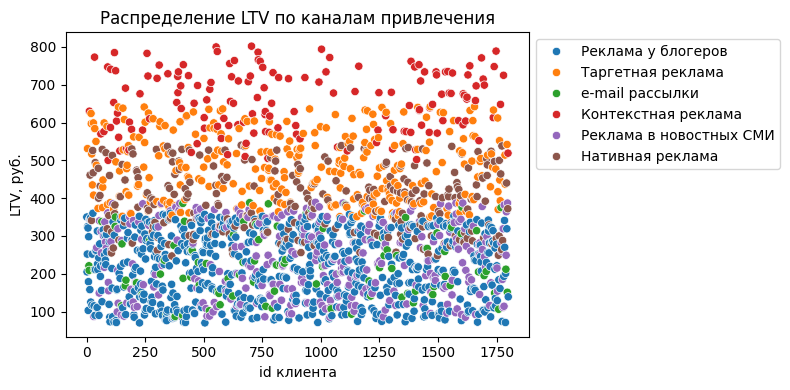

In [260]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=customers, x='id клиента', y='LTV, руб.', hue='Канал привлечения')
plt.title('Распределение LTV по каналам привлечения')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # легенду за график
plt.tight_layout()

Построим графики скрипичных ключей для наглядного сравнения медианных значений прибыли по каналам:

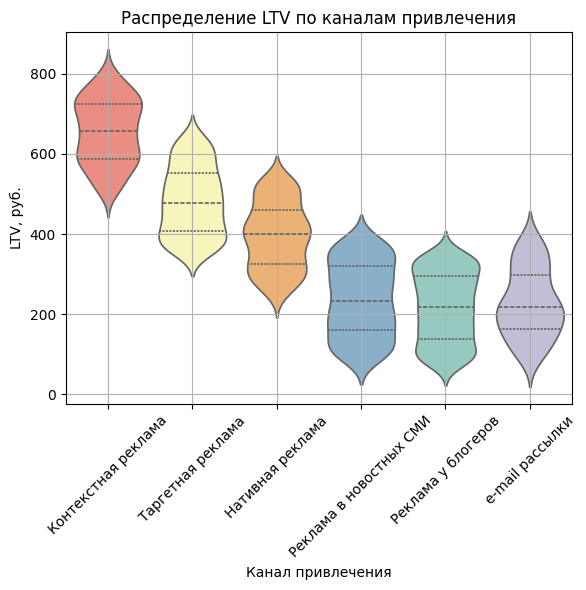

In [261]:
# Сортируем категории по медиане LTV
order = (customers.groupby('Канал привлечения')['LTV, руб.']
         .median()
         .sort_values(ascending=False).index)

plt.figure(figsize=(6, 6))
sns.violinplot(data=customers, x='Канал привлечения', y='LTV, руб.',
               hue='Канал привлечения', palette='Set3',
               order=order, inner='quartile')
plt.title('Распределение LTV по каналам привлечения')
plt.xticks(rotation=45)
plt.xlabel('Канал привлечения')
plt.ylabel('LTV, руб.')
plt.grid()
plt.tight_layout()

`Вывод:` Из представленного графика мы видим, что например чётко прослеживается то, что каналы `Контекстная реклама` и `Таргетная реклама` приводят клиентов, у которых LTV в среднем выше, а например канал `Реклама у блогеров` приводит клиентов с меньшим LTV.

### <a id='toc4_5_'></a>[Создание сводной таблицы по каналам привлечения клиентов](#toc0_)
В сводную таблицу добавим два новых столбца:
1. Средний LTV на канал в руб.;
2. Кол-во клиентов, пришедших из канала.

In [262]:
# создаём сводную таблицу
df_agg = (customers.groupby('Канал привлечения')
          .agg(
               mean = ('LTV, руб.', lambda x: round(x.mean(), 0)),
               count = ('LTV, руб.', 'count'))
          .reset_index())

# переименовываем названия столбцов
df_agg.rename(columns={'mean': 'Средний LTV, руб.', 'count': 'Кол-во клиентов'}, inplace=True)
df_agg

,Канал привлечения,"Средний LTV, руб.",Кол-во клиентов
0,e-mail рассылки,229.0,96
1,Контекстная реклама,656.0,154
2,Нативная реклама,395.0,255
3,Реклама в новостных СМИ,236.0,312
4,Реклама у блогеров,217.0,671
5,Таргетная реклама,483.0,312


### <a id='toc4_6_'></a>[Объединение таблицы затрат и сводной таблицы](#toc0_)
Объединим таблицу затрат и сводную таблицу с целью увидеть общую картину.

In [263]:
# соединяем таблицы по полю `Канал привлечения`
df_group = pd.merge(df_cost_attr, df_agg, on='Канал привлечения', how='inner')
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов
0,Таргетная реклама,100000,483.0,312
1,e-mail рассылки,25000,229.0,96
2,Реклама у блогеров,120000,217.0,671
3,Контекстная реклама,90000,656.0,154
4,Нативная реклама,70000,395.0,255
5,Реклама в новостных СМИ,60000,236.0,312


### <a id='toc4_7_'></a>[Расчёт метрики CAC](#toc0_)
Рассчитаем метрику CAC для каждого канала привлечения с целью узнать сколько приходится затрат в среднем на одного пользователя.

In [264]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов` с округлением
df_group = df_group.assign(cac = round(df_group['Стоимость привлечения, руб.'] / df_group['Кол-во клиентов'], 1))
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,cac
0,Таргетная реклама,100000,483.0,312,320.5
1,e-mail рассылки,25000,229.0,96,260.4
2,Реклама у блогеров,120000,217.0,671,178.8
3,Контекстная реклама,90000,656.0,154,584.4
4,Нативная реклама,70000,395.0,255,274.5
5,Реклама в новостных СМИ,60000,236.0,312,192.3


### <a id='toc4_8_'></a>[Расчёт прибыли на один юнит для каналов привлечения](#toc0_)
Рассчитаем для каждого канала среднюю прибыль на 1 пользователя через вычитание из среднего LTV и средних затрат на одного пользователя.

In [265]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов`
df_group = df_group.assign(ltv_cac = round(df_group['Средний LTV, руб.'] - df_group['cac'], 1))

# переименовываем названия столбцов
df_group.rename(columns={'cac': 'CAC, руб.', 'ltv_cac': 'Прибыль на 1 юнит, руб.'}, inplace=True)

# Сортируем категории по медиане LTV
df_group = df_group.sort_values('Прибыль на 1 юнит, руб.', ascending=False)

df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,"CAC, руб.","Прибыль на 1 юнит, руб."
0,Таргетная реклама,100000,483.0,312,320.5,162.5
4,Нативная реклама,70000,395.0,255,274.5,120.5
3,Контекстная реклама,90000,656.0,154,584.4,71.6
5,Реклама в новостных СМИ,60000,236.0,312,192.3,43.7
2,Реклама у блогеров,120000,217.0,671,178.8,38.2
1,e-mail рассылки,25000,229.0,96,260.4,-31.4


### <a id='toc4_9_'></a>[Построение графика прибыли на одного юнита по каналам привлечения](#toc0_)
Для наглядности построим график и покажем на нём для каждого канала привлечения среднюю прибыль на одного пользователя.

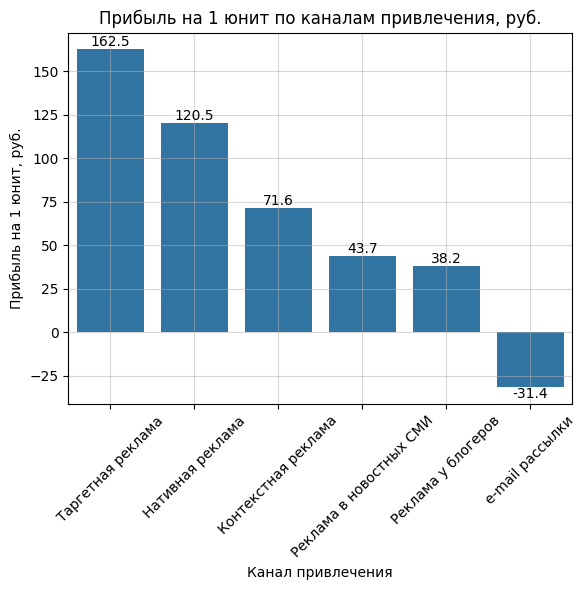

In [266]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=df_group, x='Канал привлечения', y='Прибыль на 1 юнит, руб.')
ax.bar_label(ax.containers[0])
plt.title('Прибыль на 1 юнит по каналам привлечения, руб.')
plt.xticks(rotation=45)
plt.xlabel('Канал привлечения')
plt.ylabel('Прибыль на 1 юнит, руб.')
plt.grid(alpha=0.5)
plt.tight_layout()

Мы выполнили расчёты, а именно:
- в сводной таблице для каждого канала привлечения рассчитали следующие показатели `Средний LTV, руб.` и `Кол-во клиентов`;
- объединили таблицу с общими затратами по каналам и сводную таблицу;
- рассчитали метрику CAC;
- для каждого канала привлечения рассчитали прибыль на 1 юнит.

# <a id='toc5_'></a>[Итоги](#toc0_)
**Вопрос 1:** Определить какие каналы окупаются.

**Ответ:** Окупаются все каналы, кроме `e-mail рассылки`.

---

**Вопрос 2:** Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит.

**Ответ:** Самым прибыльным каналом является `Таргетная реклама`. 

---

**Вопрос 3:** Сформулировать бизнес выводы на основании данных расчётов.

**Ответ:** Канал `e-mail рассылки` приносит убытки и по этому, если у него нет прогнозов, что вскоре через этот канал будет приходить более платежеспособный клиент, то от него стоит отказаться. Канал `Таргетная реклама` самый выгодный с точки зрения прибыли на 1 клиента, поэтому инвестиции в него стоит увеличивать.